In [2]:
# autoreload module
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# Import Network
import torch
from bc.bc_dataset import BCDataset #, BCDatasetBuffer, BCDatasetDataAug, LFUBuffer
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

2023-12-15 23:12:10.201965: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-15 23:12:10.202013: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-15 23:12:10.202019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
dataset = BCDataset(
    data_path='/Data/Dataset/Waymo/V1_2_tf/validation_extracted',
    sample_method='log'
)

In [5]:
dataloader = DataLoader(dataset, batch_size=128, 
                        shuffle=False, num_workers=16,
                        pin_memory=False,
                        collate_fn=dataset.collate_fn)
                        # collate_fn=lambda x: x)

In [7]:
def test():
    bin_idx = np.random.choice(len(dataset.sample_p), p=dataset.sample_p)
    cache_id = np.random.randint(dataset.histogram[bin_idx])
    cache = dataset.idx_cache[bin_idx][cache_id]
    dataset.retrive_one(cache)

%timeit test()

11.7 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
hist = None
accel_grid = np.linspace(-10, 10, 20)
steer_grid = np.linspace(-0.3, 0.3, 20)

for i, data in tqdm(enumerate(dataloader)):
    x_data = data['gt_action'][:, 0].numpy()
    y_data = data['gt_action'][:, 1].numpy()
    if hist is None:
        hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=[accel_grid, steer_grid])
    else:
        new_hist, _, _ = np.histogram2d(x_data, y_data, bins=[accel_grid, steer_grid])
        hist += new_hist
    if i==100:
        break

100it [00:15,  6.36it/s]


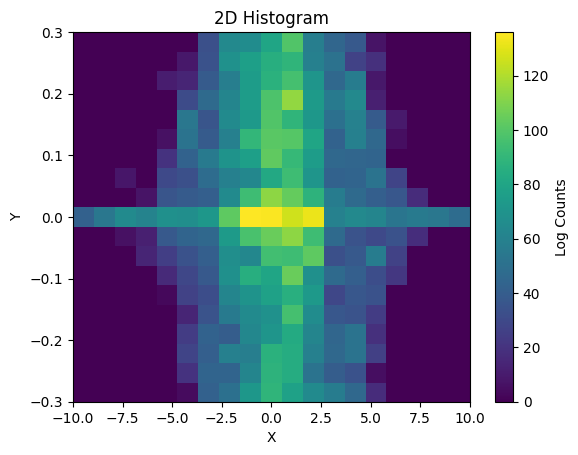

In [9]:
# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Plot the initial histogram
im = ax.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')
# im = ax.imshow(hist.T, origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], aspect='auto')

plt.colorbar(im, ax=ax, label='Log Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram')

plt.show()


In [51]:
a = np.array([1,2,3,4,5,6,7,8,9,10], dtype=np.float32)
b = np.random.randint(0, 2, 10, dtype=bool)
a*b


array([0., 0., 3., 4., 5., 6., 0., 0., 9., 0.], dtype=float32)